In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
import os
import math
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"
# Franka simulator
import sys
sys.path.append("../franka")
sys.path.append("../utility")
sys.path.append("../")
from Utility import DerivativeLiftFunc, data_collecter
import lqr
# physics engine
import pybullet as pb
import pybullet_data
from franka_env import FrankaEnv
from scipy.io import loadmat, savemat

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
pybullet build time: Jan 29 2025 23:20:52


In [2]:
import scipy.linalg as spla
import scipy.sparse.linalg as spsla
import time
from typing import Tuple, Dict, Optional
class SOCFunc():
    def __init__(self,env_name,Nstate,udim,Nrbf,observation_space, X, Y, U) -> None:
        self.env_name = env_name
        self.Nstate = Nstate
        self.udim = udim        
        self.Nrbf = Nrbf
        self.NKoopman = self.Nstate+self.Nrbf
        lift_val = 4
        self.lift_low = np.clip(observation_space.low,-lift_val,lift_val)
        self.lift_high = np.clip(observation_space.high,-lift_val,lift_val)
        self.type = type
        self.A = None
        self.B = None
        self.learnSOCmodel_withControl(X,Y,U)

    def projectInvertible(self, S: np.ndarray, epsilon: float) -> np.ndarray:
        """
        投影矩阵到可逆矩阵集合：通过SVD分解，将奇异值限制在epsilon以上
        对应MATLAB projectInvertible 函数
        """
        U, s, VT = spla.svd(S, full_matrices=False)  # 经济规模SVD
        # 将小于epsilon的奇异值替换为epsilon
        s_clipped = np.maximum(s, epsilon)
        # 重构矩阵
        Sp = U @ np.diag(s_clipped) @ VT
        return Sp


    def projectPSD(self, Q: np.ndarray, epsilon: float = 0.0, delta: float = np.inf) -> np.ndarray:
        """
        投影矩阵到半正定矩阵(PSD)锥：通过特征值分解，将特征值限制在[epsilon, delta]
        对应MATLAB projectPSD 函数
        """
        # 确保输入矩阵对称（数值稳定性处理）
        Q_sym = (Q + Q.T) / 2
        # 特征值分解（实对称矩阵，特征值为实数）
        e, V = np.linalg.eig(Q_sym)
        # 裁剪特征值到指定区间
        e_clipped = np.clip(e, epsilon, delta)
        # 重构半正定矩阵
        Qp = V @ np.diag(e_clipped) @ V.T
        # 消除数值误差导致的非对称性
        Qp = (Qp + Qp.T) / 2
        return Qp


    def poldec(self, A: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        极分解：将矩阵A分解为正交矩阵U和半正定矩阵H，满足A = U @ H
        对应MATLAB poldec 函数
        """
        # scipy.linalg.polar 返回 (正交矩阵U, 半正定矩阵P)
        U, H = spla.polar(A)
        # 确保H是严格半正定（数值稳定性处理）
        H = self.projectPSD(H, epsilon=1e-12)
        return U, H


    def checkdstable(self, A: np.ndarray, epsilon: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        基于离散Lyapunov方程初始化稳定矩阵参数
        对应MATLAB checkdstable 函数
        求解 A'*P*A - P + I = 0，得到P；再通过S=sqrt(P)、极分解得到O和C
        """
        n = A.shape[0]
        # 求解离散Lyapunov方程：A.T @ P @ A - P = -I
        # scipy.linalg.solve_discrete_lyapunov 求解 A @ P @ A.T - P = -Q，需调整参数顺序
        # 原方程 A'*P*A - P = -I → 令 A_t = A.T，则 A_t @ P @ A_t.T - P = -I
        A_t = A.T
        Q = np.eye(n)
        try:
            P = spla.solve_discrete_lyapunov(A_t, Q)
        except Exception as e:
            # 若求解失败，用单位矩阵初始化P
            print(f"Lyapunov方程求解警告: {e}，使用单位矩阵初始化P")
            P = np.eye(n)
        
        # 确保P正定，计算S=sqrt(P)
        P = self.projectPSD(P, epsilon=1e-12)  # 避免数值奇异
        S = spla.sqrtm(P)
        
        # 计算OC = S @ A @ S^{-1}，再极分解得到O和C
        S_inv = spla.inv(S)
        OC = S @ A @ S_inv
        O, C = self.poldec(OC)
        
        # 投影C到[0, 1-epsilon]区间（保证稳定性）
        C = self.projectPSD(C, epsilon=0.0, delta=1.0 - epsilon)
        
        return P, S, O, C

    def learnSOCmodel_withControl(
        self,
        X: np.ndarray, 
        Y: np.ndarray, 
        U: np.ndarray, 
        options: Optional[Dict] = None
    ) -> Tuple[np.ndarray, np.ndarray, float, float]:
        """
        基于SOC（Stable Orthogonal Contraction）方法学习稳定线性动力系统（LDS）的状态矩阵A和控制矩阵B
        对应MATLAB learnSOCmodel_withControl 函数
        
        参数:
            X: 状态测量矩阵，shape=(n, p)，n为状态维度，p为样本数
            Y: 下一时刻状态矩阵，shape=(n, p)
            U: 控制输入矩阵，shape=(m, p)，m为控制维度
            options: 配置字典，包含迭代参数、稳定性约束等
        
        返回:
            A: 稳定状态矩阵，shape=(n, n)
            B: 控制矩阵，shape=(n, m)
            error: 最终重构误差（Frobenius范数平方/2）
            memory_used: 内存使用量（字节）
        """
        # -------------------------- 1. 初始化配置参数 --------------------------
        # 默认配置
        default_options = {
            "maxiter": np.inf,          # 最大迭代次数
            "timemax": 10,              # 最大运行时间（秒）- 原MATLAB为1800秒，此处保留默认可调整
            "posdef": 1e-12,            # 正定矩阵投影的最小奇异值
            "astab": 0.0,               # 稳定性余量（1-astab为最大谱半径）
            "display": 1,               # 显示迭代信息
            "graphic": 0,               # 是否绘制图形（暂不实现）
            "init": 1,                  # 初始化方式（暂用默认）
            "alpha0": 0.5,              # FGM初始alpha参数
            "lsparam": 1.5,             # 线搜索步长衰减系数
            "lsitermax": 60,            # 线搜索最大迭代次数
            "gradient": 0               # 是否使用梯度下降（0=FGM，1=普通梯度）
        }
        
        # 更新用户配置（覆盖默认）
        if options is None:
            options = {}
        for key, val in default_options.items():
            if key not in options:
                options[key] = val
        
        # -------------------------- 2. 数据预处理与初始化 --------------------------
        XU = np.vstack((X, U))  # 状态-控制拼接矩阵，shape=(n+m, p)
        n = X.shape[0]          # 状态维度
        m = U.shape[0]          # 控制维度
        p = X.shape[1]          # 样本数
        
        # 计算最小二乘初始解 AB_ls = Y @ pinv(XU)
        AB_ls = Y @ spla.pinv(XU)
        A_ls = AB_ls[:, :n]     # LS状态矩阵
        B_ls = AB_ls[:, n:]     # LS控制矩阵
        nA2 = 0.5 * np.linalg.norm(Y - AB_ls @ XU, ord="fro") ** 2  # LS初始误差
        
        # 初始化S、O、C、B
        S = np.eye(n)  # 初始化为单位矩阵
        O, C = self.poldec(A_ls)  # 对LS状态矩阵做极分解
        B = B_ls.copy()
        
        # 检查初始稳定性（谱半径）
        try:
            # 计算 A = S^{-1} @ O @ C @ S 的最大特征值模
            S_inv = spla.inv(S)
            A_temp = S_inv @ O @ C @ S
            max_eig, _ = spsla.eigs(A_temp, k=1, which="LM", maxiter=1000)
            eA = np.abs(max_eig[0])
        except Exception as e:
            # 特征值计算失败，视为不稳定
            if options["display"]:
                print(f"初始特征值计算警告: {e}，假设谱半径>1")
            eA = 2.0
        
        # 若初始不稳定，投影C到稳定区间
        if eA > 1.0 - options["astab"]:
            C = self.projectPSD(C, epsilon=0.0, delta=1.0 - options["astab"])
            A_temp = S_inv @ O @ C @ S
            e_old = 0.5 * np.linalg.norm(Y - A_temp @ X - B @ U, ord="fro") ** 2
        else:
            e_old = nA2  # 初始误差为LS误差
        
        # 基于Lyapunov方程的初始化（对比并选择更优解）
        maxeA = max(1.0, eA)
        Astab = A_ls / maxeA  # 缩放至稳定范围
        try:
            P_temp, S_temp, O_temp, C_temp = self.checkdstable(Astab, options["astab"])
            A_temp_lmi = S_temp @ Astab @ spla.inv(S_temp)
            e_temp = 0.5 * np.linalg.norm(Y - A_temp_lmi @ X - B @ U, ord="fro") ** 2
            
            # 若LMI初始化误差更小，更新参数
            if e_temp < e_old:
                if options["display"]:
                    print("使用LMI初始化（误差更小）")
                S = S_temp
                O = O_temp
                C = C_temp
                e_old = e_temp
        except Exception as e:
            if options["display"]:
                print(f"LMI初始化警告: {e}，保留原初始化")
        
        # FGM参数初始化
        alpha = options["alpha0"]
        Ys = S.copy()    # FGM中间变量：S的缓存
        Yo = O.copy()    # FGM中间变量：O的缓存
        Yc = C.copy()    # FGM中间变量：C的缓存
        Yb = B.copy()    # FGM中间变量：B的缓存
        restarti = 1     # FGM重启标记
        begintime = time.time()  # 开始时间
        i = 1            # 迭代计数
        e100 = np.full(100, np.nan)  # 存储最近100次误差（用于收敛判断）

        # -------------------------- 3. 主迭代循环 --------------------------
        while i < options["maxiter"]:
            # 检查时间限制（原MATLAB为1800秒，此处用options.timemax控制）
            elapsed_time = time.time() - begintime
            if elapsed_time > options["timemax"]:
                if options["display"]:
                    print(f"迭代终止：超出时间限制（{elapsed_time:.2f}s > {options['timemax']}s）")
                break
            
            alpha_prev = alpha
            S_inv = spla.inv(S)
            
            # -------------------------- 3.1 计算梯度 --------------------------
            A_temp = S_inv @ O @ C @ S  # 当前状态矩阵
            Z = - (X @ Y.T - X @ X.T @ A_temp.T - X @ U.T @ B.T) @ S_inv  # 辅助变量
            
            # 各参数梯度（严格对应MATLAB公式）
            gS = (Z @ O @ C - A_temp @ Z).T
            gO = (C @ S @ Z).T
            gC = (S @ Z @ O).T
            gB = A_temp @ X @ U.T + B @ U @ U.T - Y @ U.T
            
            # -------------------------- 3.2 线搜索（步长调整） --------------------------
            inneriter = 1
            step = 1.0  # 初始步长
            prev_error = np.inf
            e_new = np.inf
            
            while inneriter <= options["lsitermax"]:
                # 梯度下降更新
                Sn = Ys - step * gS
                On = Yo - step * gO
                Cn = Yc - step * gC
                Bn = Yb - step * gB
                
                # 投影到可行域
                Sn = self.projectInvertible(Sn, options["posdef"])  # S需可逆
                Sn_inv = spla.inv(Sn)
                
                # 检查稳定性（计算谱半径）
                try:
                    A_n = Sn_inv @ On @ Cn @ Sn
                    max_eig_n, _ = spsla.eigs(A_n, k=1, which="LM", maxiter=1000)
                    maxE = np.abs(max_eig_n[0])
                except Exception as e:
                    maxE = 2.0  # 计算失败视为不稳定
                
                # 若不稳定，投影O和C
                if maxE > 1.0 - options["astab"]:
                    On, _ = self.poldec(On)  # O需正交
                    Cn = self.projectPSD(Cn, 0.0, 1.0 - options["astab"])  # C需稳定
                
                # 计算新误差
                e_new = 0.5 * np.linalg.norm(Y - A_n @ X - Bn @ U, ord="fro") ** 2
                
                # 误差下降判断
                if e_new < e_old:
                    if e_new > prev_error:
                        break  # 误差下降减缓，停止线搜索
                    prev_error = e_new
                    break
                else:
                    prev_error = e_new
                    step /= options["lsparam"]  # 步长衰减
                    inneriter += 1
            
            # -------------------------- 3.3 FGM参数更新与重启 --------------------------
            # 计算FGM的alpha和beta
            alpha = (np.sqrt(alpha_prev ** 4 + 4 * alpha_prev ** 2) - alpha_prev ** 2) / 2.0
            beta = alpha_prev * (1 - alpha_prev) / (alpha_prev ** 2 + alpha) if alpha != 0 else 0.0
            
            # 线搜索失败：重启FGM
            if e_new > e_old:
                if restarti == 1:
                    # 第一次重启：重置缓存变量
                    restarti = 0
                    alpha = options["alpha0"]
                    Ys = S.copy()
                    Yo = O.copy()
                    Yc = C.copy()
                    Yb = B.copy()
                    e_new = e_old
                else:
                    # 第二次重启：视为收敛
                    if options["display"]:
                        print(f"迭代终止：线搜索失败（迭代{i}），视为收敛")
                    break
            else:
                # 线搜索成功：更新FGM缓存和参数
                restarti = 1
                if options["gradient"] == 1:
                    beta = 0.0  # 禁用FGM，使用普通梯度下降
                
                # FGM共轭更新
                Ys = Sn + beta * (Sn - S)
                Yo = On + beta * (On - O)
                Yc = Cn + beta * (Cn - C)
                Yb = Bn + beta * (Bn - B)
                
                # 更新当前参数
                S, O, C, B = Sn, On, Cn, Bn
            
            # -------------------------- 3.4 收敛判断 --------------------------
            # 存储最近100次误差
            current_i = i % 100
            if current_i == 0:
                current_i = 100
            e100[current_i - 1] = e_old  # 索引从0开始
            
            # 检查收敛（相对误差<1e-8 或 绝对误差<1e-6*nA2）
            if i > 100:
                current_i_min_100 = (current_i % 100) + 1
                if current_i_min_100 == 101:
                    current_i_min_100 = 1
                e_prev_100 = e100[current_i_min_100 - 1]
                if not np.isnan(e_prev_100) and (e_prev_100 - e_old) < 1e-8 * e_prev_100:
                    if options["display"]:
                        print(f"迭代终止：误差收敛（迭代{i}）")
                    break
            if e_old < 1e-6 * nA2:
                if options["display"]:
                    print(f"迭代终止：误差过小（{e_old:.2e} < 1e-6*{nA2:.2e}，迭代{i}）")
                break
            
            # 更新迭代计数和误差
            e_old = e_new
            i += 1
            
            # 显示迭代信息
            if options["display"] and (i % 10 == 0 or i == 1):
                print(f"迭代{i} | 误差: {e_old:.6e} | 步长: {step:.6e} | 耗时: {elapsed_time:.2f}s")

        # -------------------------- 4. 解优化（接近稳定边界以减小误差） --------------------------
        # 计算梯度：向LS解方向调整
        A = S_inv @ O @ C @ S
        AB_current = np.hstack((A, B))
        grad = AB_ls - AB_current  # 梯度方向（指向LS解）
        
        e0 = 1e-5       # 初始步长
        e_step = 1e-5   # 步长增量
        e = e0
        maxE = 0.0
        
        while True:
            # 沿梯度更新AB
            AB_new = AB_current + e * grad
            Anew = AB_new[:, :n]
            Bnew = AB_new[:, n:]
            
            # 检查稳定性
            try:
                max_eig_new, _ = spsla.eigs(Anew, k=1, which="LM", maxiter=1000)
                maxE = np.abs(max_eig_new[0])
            except Exception as e:
                maxE = 2.0
            
            # 停止条件：超出稳定范围 或 误差过小
            error_new = 0.5 * np.linalg.norm(Y - Anew @ X - Bnew @ U, ord="fro") ** 2
            if maxE >= 1.0 - options["astab"] or error_new < 0.01:
                break
            
            e += e_step
        
        # 回退到最后一个稳定解
        if e > e0:
            AB_opt = AB_current + (e - e_step) * grad
            A = AB_opt[:, :n]
            B = AB_opt[:, n:]
        else:
            A = Anew
            B = Bnew
        
        # 最终误差
        error = 0.5 * np.linalg.norm(Y - A @ X - B @ U, ord="fro") ** 2

        # -------------------------- 5. 计算内存使用量 --------------------------
        memory_used = 0
        # 遍历局部变量，计算numpy数组的内存（其他类型用sys.getsizeof）
        local_vars = locals()
        for var_name, var_val in local_vars.items():
            if isinstance(var_val, np.ndarray):
                memory_used += var_val.nbytes  # numpy数组实际数据大小
            else:
                memory_used += sys.getsizeof(var_val)  # 其他类型默认大小

        # -------------------------- 6. 返回结果 --------------------------
        if options["display"]:
            print(f"\n训练完成 | 最终误差: {error:.6e} | 状态矩阵谱半径: {maxE:.6f} | 内存使用: {memory_used/1e6:.2f}MB")
        
        self.A = A
        self.B = B
            
    def Psi_s(self,s):
        #s (N,Nstate)
        s = s.reshape(-1,self.Nstate)
        N,_ = s.shape
        psi = np.zeros([N,self.Nstate])
        psi[:,:self.Nstate] = s  
        return psi  

    def Psi_su(self,s,u):
        s = s.reshape(-1,self.Nstate)
        u = u.reshape(-1,self.udim)
        N,_ = s.shape
        psi = np.zeros([N,self.Nstate+self.udim])
        psi[:,:self.Nstate] = self.Psi_s(s)
        psi[:,self.Nstate:] = u
        return psi


In [3]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
method_index = 1
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
# suffix = "DampingPendulum1_26"
# env_name = "DampingPendulum"
# suffix = "MountainCarContinuous1_26"
# env_name = "MountainCarContinuous-v0"
env_name = "Franka"

In [4]:
Data_collecter = data_collecter(env_name)
samples = 1000
steps = 5
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
Nrbf = 10
train_data = Data_collecter.collect_koopman_data(samples,steps)
print(train_data.shape)
X = train_data[:steps,:,udim:].reshape(-1, Nstate)
U = train_data[:steps,:,:udim].reshape(-1, udim)
Y = train_data[1:steps+1,:,udim:].reshape(-1,Nstate)
X = X.T
Y = Y.T
U = U.T
print(X.shape, U.shape)
LiftFunc = SOCFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space,X,Y,U)
NKoopman = LiftFunc.NKoopman

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link1b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link2b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfIm

100%|██████████| 1000/1000 [00:01<00:00, 915.17it/s]


(6, 1000, 24)
(17, 5000) (7, 5000)
迭代10 | 误差: 4.212157e-04 | 步长: 2.719722e-11 | 耗时: 0.40s
迭代20 | 误差: 4.211040e-04 | 步长: 2.640142e-05 | 耗时: 0.78s
迭代30 | 误差: 4.209984e-04 | 步长: 1.760095e-05 | 耗时: 1.26s
迭代40 | 误差: 4.209455e-04 | 步长: 2.640142e-05 | 耗时: 2.14s
迭代50 | 误差: 4.209141e-04 | 步长: 2.640142e-05 | 耗时: 2.87s
迭代60 | 误差: 4.208692e-04 | 步长: 2.640142e-05 | 耗时: 3.48s
迭代70 | 误差: 4.208553e-04 | 步长: 3.960213e-05 | 耗时: 3.86s
迭代终止：线搜索失败（迭代78），视为收敛

训练完成 | 最终误差: 4.217094e-04 | 状态矩阵谱半径: 0.999997 | 内存使用: 2.68MB


In [5]:
simFranka = False # whether to open Graphical interface to animate Franka motion
np.set_printoptions(precision=3)
nStates = 10
accuracy_invKin = 0.000001
def quat_to_euler(q):
    """ 
    Function that converts quaternions to Euler angles
    
    Inputs
    ------
    q : quaternions
    
    Outputs
    -------
    
    phi, theta, psi : Euler angles
    """
    pi = math.pi
    q0, q1, q2, q3 = q[3], q[0], q[1], q[2]
    test = np.dot(q0,q2) - np.dot(q1,q3)
    if (test > 0.4999): 
        phi = math.atan2(q1*q2 - q0*q3, q1*q3 + q0*q2)
        theta = pi/2
        psi= 0
    elif (test < -0.4999):
        phi = math.atan2(- q1*q2 + q0*q3, - q1*q3 - q0*q2)
        theta = -pi/2
        psi = 0
    else:
        sqx = q1*q1
        sqy = q2*q2
        sqz = q3*q3
        
        psi = math.atan2(2*q2*q1+2*q0*q3 , 1 - 2*sqy - 2*sqz) # Yaw
        theta = math.asin(2*test) # Pitch
        phi = math.atan2(2*q2*q3+2*q0*q1 , 1 - 2*sqx - 2*sqy) # Roll
    return phi, theta, psi

def Psi_x(x): 
    return x

def Run_Franka(Steps, state_desired, LQR_gains, x0 = None, y0 = None, z0 = None):
    """
    Function that simulates forward the dynamics of Franka using LQR control, 
    given a desired trajectory and LQR gains
    
    Inputs
    ------
    Steps : Number of steps to propagate discrete dynamics into the future
    state_desired: desired trajectory to track (used for the applied control)
    LQR_gains: LQR gains used together with the current state and desired trajectory 
            to compute control response
            
    Outputs
    -------
    state_traj : state trajectory of the controlled system
    control_traj : control trajectory that was applied to the system
    """
    state = env.reset()
    
    # Set state to desired state to help initiation
    for i, jnt in enumerate(state_desired[0,3:9]):
            pb.resetJointState(env.robot, i, jnt)
    
    # set initial y,z states to given y0, z0
    if x0:
        JointAngles_Fig8 = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x0, y0, z0], accuracy_invKin, 10000)
        for i, jnt in enumerate(JointAngles_Fig8[0:6]):
            pb.resetJointState(env.robot, i, jnt)

    state = env.get_state()

    # Initialize states and controls trajectories
    state_traj, control_traj = np.empty((Steps+1,17)), np.empty((Steps, 7))
    state_traj[:], control_traj[:] = np.NaN,  np.NaN
    
    # Simulate dynamics forward
    for t in range(Steps):
        state = np.append(state[0:3], state[7:])
        state = LiftFunc.Psi_s(state).reshape(Nstate,1)
        state_traj[t, :] = state[:17].reshape(-1)
        control = - np.dot(LQR_gains, (state - LiftFunc.Psi_s(state_desired[t+1,:]).reshape(Nstate,1)))
        control_traj[t, :] = control.reshape(-1)
        state = env.step(control)
        # time.sleep(1.0/6000.)
#         time.sleep(1.0/600000.)
    
    state = np.append(state[0:3], state[7:])
    state = LiftFunc.Psi_s(state).reshape(Nstate,1)
    state_traj[t+1, :] = state[:17].reshape(-1)
    return state_traj, control_traj

def accurateCalculateInverseKinematics(kukaId, endEffectorId, targetPos, threshold, maxIter):
    """
    Calculates the joint poses given the End Effector location using inverse kinematics
    Note: It changes the Franka configuration during the optimization to the desired configuration
    
    Input: 
    kukaId : Object that represents the Franka system
    endEffectorId : 
    targetPos : 
    threshold : accuracy threshold
    maxIter : maximum iterations to fine tune solution
    
    Output: 
    jointPoses: The angles of the 7 joints of the Franka 
    """
    numJoints = 7
    closeEnough = False
    iter = 0
    dist2 = 1e30
    while (not closeEnough and iter < maxIter):
        jointPoses = pb.calculateInverseKinematics(kukaId, endEffectorId, targetPos)
    
        for i in range(numJoints):
            pb.resetJointState(kukaId, i, jointPoses[i])
        ls = pb.getLinkState(kukaId, endEffectorId)
        newPos = ls[4]
        diff = [targetPos[0] - newPos[0], targetPos[1] - newPos[1], targetPos[2] - newPos[2]]
        dist2 = (diff[0] * diff[0] + diff[1] * diff[1] + diff[2] * diff[2])
        closeEnough = (dist2 < threshold)
        iter = iter + 1
    return jointPoses[:7]

def runLQRonFranka(steps, desired_target, LQR_gains, x0 = None, y0 = None, z0 = None, method = False):
    """
    Executes a simulation of specified number of steps applying LQR on Franka with the input LQR gains
        
    Inputs
    ------
    steps : number of steps to forward simulate the system
    desired_target : desired_trajectory to track
    LQR_gains : LQR gains used to compute control
    method : method to print on pdf label; if none is specified, no pdf is created
"""
    state_traj, controls_traj = Run_Franka(steps, desired_target, LQR_gains, x0, y0, z0)

    error = np.linalg.norm(state_traj[:,:nStates] - desired_target[:,:nStates])
    if method:
        fig = plt.plot(state_traj[:,1], state_traj[:,2], 'b-', linewidth = 1, markersize = 1)
        plt.plot(desired_target[:,1], desired_target[:,2], 'k--', linewidth = 1)
        plt.axis('equal')
        plt.title(method +': Error = {0:.2f}'.format(error), fontdict=None, loc='center', pad=None)
    return state_traj, controls_traj, error

def desiredStates_from_EndEffector(xyzEndEffector):
    """
    This function takes in the x,y,z coordinates of the end effector (EE) of Franka 
    and returns the closest (locally, using Inverse Kinematics) desired configuration
    to achieve that EE position . 
    
    Inputs
    ------
    x_d, y_d, z_d: End effector coordinates
    
    Outputs
    desired_states: x, y, z, JointAngles, Joint Velocities
    """
    x_d, y_d, z_d = xyzEndEffector[0], xyzEndEffector[1], xyzEndEffector[2]
    jointAngles = np.asarray(accurateCalculateInverseKinematics(env.robot, env.ee_id, [x_d, y_d, z_d], accuracy_invKin, 10000))
    state_des = np.concatenate((xyzEndEffector, jointAngles, np.zeros(7)))

    return state_des

In [6]:
# initialize Franka object
env = FrankaEnv(render = simFranka)

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link1b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link2b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfIm

Text(0, 0.5, 'z (m)')

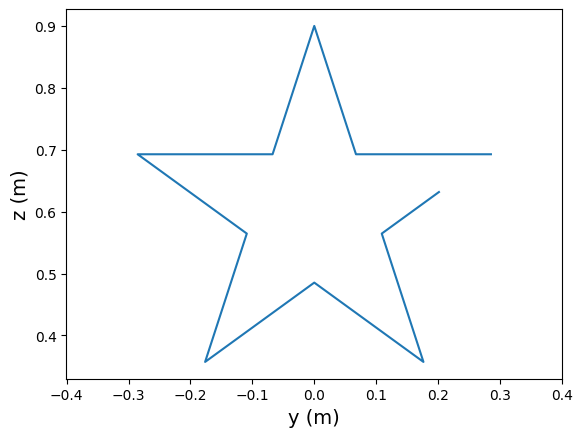

In [7]:
center = np.array([0.0,0.6])
radius = 0.3
theta_ = np.pi/10.0
eradius = np.tan(2*theta_)*radius*np.cos(theta_)-radius*np.sin(theta_) 
Star_points = np.zeros((11,2))
for i in range(5):
    theta = 2*np.pi/5*(i+0.25)
    Star_points[2*i,0] = np.cos(theta)*radius+center[0]
    Star_points[2*i,1] = np.sin(theta)*radius+center[1]
    beta = 2*np.pi/5*(i+0.75)
    Star_points[2*i+1,0] = np.cos(beta)*eradius+center[0]
    Star_points[2*i+1,1] = np.sin(beta)*eradius+center[1]    
Star_points[-1,:] = Star_points[0,:]
T = 6 *10 # time horizon 
t = 0.02*np.linspace(0, T*5, T*50+1) # time steps
refs = np.zeros((len(t),2))
Steps = len(t)-1
each_num = int((len(t)-10)/9.5)
for i in range(10):
    refs[(each_num+1)*i,:] = Star_points[i,:]
    if i!= 9:
        num = each_num
    else:
        num = len(t)-(each_num+1)*i-1
    for j in range(num):
        t_ = (j+1)/(each_num+1)
        refs[(each_num+1)*i+j+1,:] =  t_*Star_points[i+1,:] + (1-t_)*Star_points[i,:]
# print(each_num,each_num*10.5)
# print(t.shape)
# plt.plot(Star_points[:,0],Star_points[:,1])
x = 0.3*np.ones((len(t),1)) 
z = refs[:,1].reshape(-1,1)
y =  refs[:,0].reshape(-1,1)
plt.plot(y,z)
plt.axis('equal')
plt.xlabel('y (m)', fontsize = 14)
plt.ylabel('z (m)', fontsize = 14)

In [8]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [9]:
##LQR
import lqr
import time
Ad = LiftFunc.A
Bd = LiftFunc.B
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q = np.zeros((Nstate,Nstate))
Q[:10,:10] = np.eye(10)
R = 0.1*np.eye(7)
Q = np.matrix(Q)
R = np.matrix(R)
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
print(Kopt.shape)

(7, 17)


In [10]:
np.random.seed(98)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(1):
    y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    state_traj_SOC, controls_traj_SOC, error_SOC = runLQRonFranka(Steps, states_des, Kopt, x[0,0], y0, z0)
    savemat('Results/SOCFrankaFigStar_SimData'+str(i)+'.mat', {'desired_states':states_des,'states_SOC': state_traj_SOC, 'u_SOC' : controls_traj_SOC,
                                                    'error_SOC':error_SOC}) # save variables to Matlab file

error error_SOC:[[843.154]]


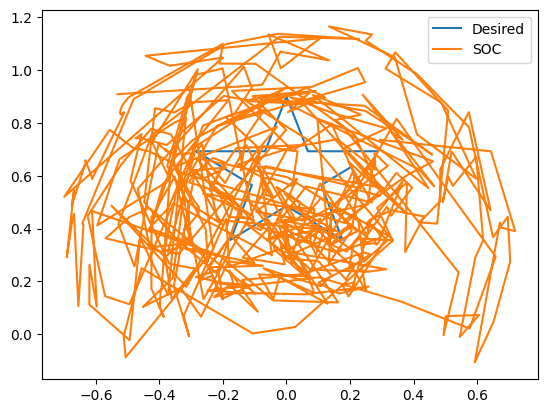

In [11]:
trajs = loadmat('Results/SOCFrankaFigStar_SimData0.mat')
state_traj_SOC = trajs['states_SOC']
desired_traj = trajs['desired_states']
plt.plot(desired_traj[:,1],desired_traj[:,2],label='Desired')
plt.plot(state_traj_SOC[:,1],state_traj_SOC[:,2],label='SOC')
print("error error_SOC:{}".format(trajs['error_SOC']))
plt.legend()
plt.show()

Text(0, 0.5, 'z (m)')

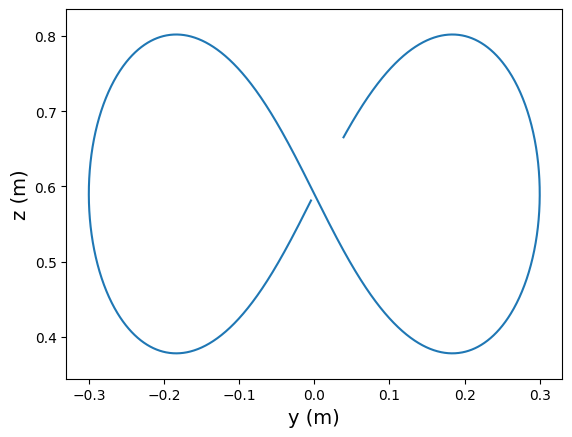

In [12]:
env.reset()
T = 6 *10 # time horizon 
t = 1.6 + 0.02*np.linspace(0, T*5, T*50+1) # time steps
Steps = len(t)-1


a = 0.3 # scaling parameter of Fig. 8 area
x = 0.3*np.ones((len(t),1)) 
z = np.expand_dims(0.59 + 2* a * np.sin(t) * np.cos(t) / (1+np.sin(t)**2), axis = 1)
y = np.expand_dims(a * np.cos(t) / (1+np.sin(t)**2), axis = 1)
plt.plot(y,z)
plt.axis('equal')
plt.xlabel('y (m)', fontsize = 14)
plt.ylabel('z (m)', fontsize = 14)

In [13]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [14]:
np.random.seed(0)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(1):
    y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    state_traj_SOC, controls_traj_SOC, error_SOC = runLQRonFranka(Steps, states_des, Kopt, x[0,0], y0, z0)
    savemat('Results/SOCFrankaFig8_SimData'+str(i)+'.mat', {'desired_states':states_des,'states_SOC': state_traj_SOC, 'u_SOC' : controls_traj_SOC,
                                                    'error_SOC':error_SOC}) # save variables to Matlab file

error error_SOC:[[361.405]]


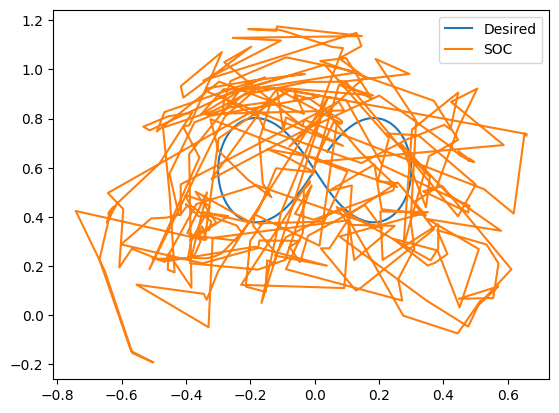

In [15]:
trajs = loadmat('Results/SOCFrankaFig8_SimData0.mat')
state_traj_SOC = trajs['states_SOC']
desired_traj = trajs['desired_states']
plt.plot(desired_traj[:,1],desired_traj[:,2],label='Desired')
plt.plot(state_traj_SOC[:,1],state_traj_SOC[:,2],label='SOC')
print("error error_SOC:{}".format(trajs['error_SOC']))
plt.legend()
plt.show()